In [10]:
import logging
from pathlib import Path
from typing import Dict

import mlflow
import numpy as np
import pandas as pd
from dotenv import dotenv_values
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# from config import logger
from lib.data_handling import CustomSpectralPipeline, load_split_data  # type: ignore
from lib.norms import Norm1Scaler, Norm3Scaler
from lib.outlier_removal import (
    calculate_leverage_residuals,
    identify_outliers,
    plot_leverage_residuals,
)
from lib.reproduction import (
    major_oxides,
    masks,
    optimized_blending_ranges,
    oxide_ranges,
    paper_individual_sm_rmses,
    spectrometer_wavelength_ranges,
    training_info,
)
from lib.utils import custom_kfold_cross_validation, filter_data_by_compositional_range
from PLS_SM.inference import predict_composition_with_blending

env = dotenv_values()
comp_data_loc = env.get("COMPOSITION_DATA_PATH")
dataset_loc = env.get("DATA_PATH")

if not comp_data_loc:
    print("Please set COMPOSITION_DATA_PATH in .env file")
    exit(1)

if not dataset_loc:
    print("Please set DATA_PATH in .env file")
    exit(1)

logger = logging.getLogger("train")

mlflow.set_tracking_uri("http://localhost:5000")

preformatted_data_path = Path("../data/_preformatted_sm/")
train_path = preformatted_data_path / "train.csv"
test_path = preformatted_data_path / "test.csv"

if (
    not preformatted_data_path.exists()
    or not train_path.exists()
    or not test_path.exists()
):
    take_samples = None

    logger.info("Loading data from location: %s", dataset_loc)
    # data = load_data(str(dataset_loc))
    train_data, test_data = load_split_data(
        str(dataset_loc), split_loc="../train_test_split.csv", average_shots=True
    )
    logger.info("Data loaded successfully.")

    logger.info("Initializing CustomSpectralPipeline.")
    pipeline = CustomSpectralPipeline(
        masks=masks,
        composition_data_loc=comp_data_loc,
        major_oxides=major_oxides,
    )
    logger.info("Pipeline initialized. Fitting and transforming data.")
    train_processed = pipeline.fit_transform(train_data)
    test_processed = pipeline.fit_transform(test_data)
    logger.info("Data processing complete.")

    preformatted_data_path.mkdir(parents=True, exist_ok=True)

    train_processed.to_csv(train_path, index=False)
    test_processed.to_csv(test_path, index=False)
else:
    logger.info("Loading preformatted data from location: %s", preformatted_data_path)
    train_processed = pd.read_csv(train_path)
    test_processed = pd.read_csv(test_path)

In [11]:
train_processed.shape

(1538, 5495)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import mlflow.pytorch

class RegressionNet(nn.Module):
    def __init__(self):
        super(RegressionNet, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(5485, 1024) # First layer
        self.dropout1 = nn.Dropout(0.3)  # Dropout for regularization
        self.fc2 = nn.Linear(1024, 512)  # Second layer
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(512, 256)   # Third layer
        self.fc4 = nn.Linear(256, 128)   # Fourth layer
        self.fc5 = nn.Linear(128, 8)     # Output layer with 8 variables

    def forward(self, x):
        # Forward pass
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x) # No activation, linear output
        return x

# Initialize the model
model = RegressionNet()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Model summary
print(model)

RegressionNet(
  (fc1): Linear(in_features=5485, out_features=1024, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=8, bias=True)
)


In [13]:
from lib.reproduction import major_oxides

In [14]:
train_processed.head()

,246.688,246.741,246.79401,246.847,246.89999,246.953,247.007,247.06,247.11301,247.166,247.21899,247.272,247.325,247.37801,247.431,247.48399,247.537,247.592,247.644,247.69701,247.75101,247.80299,247.856,247.91,247.96201,248.015,248.069,248.121,248.174,248.228,248.28,248.33299,248.38699,248.44,248.492,248.54601,248.599,248.651,248.705,248.758,...,843.11072,843.31049,843.51031,843.71002,843.90979,844.1095,844.3092,844.50891,844.7085,844.90808,845.10773,845.30731,845.5069,845.70642,845.90588,846.10553,846.30487,846.50439,846.70392,846.90332,847.10272,847.30212,847.50153,847.70081,847.90009,848.09943,848.29871,848.49799,848.6972,848.89642,SiO2,TiO2,Al2O3,FeOT,MgO,CaO,Na2O,K2O,Sample Name,ID
0,1.816278e+11,1.623567e+11,1.370143e+11,1.112093e+11,9.988030e+10,1.063486e+11,1.226207e+11,1.383802e+11,1.459775e+11,1.460467e+11,1.462813e+11,1.521070e+11,1.648582e+11,1.750085e+11,1.688118e+11,1.551646e+11,1.426406e+11,1.482378e+11,1.471043e+11,1.553752e+11,1.972251e+11,3.315662e+11,5.028117e+11,7.073240e+11,7.628381e+11,5.631357e+11,3.483315e+11,2.505797e+11,2.206761e+11,2.357739e+11,2.786588e+11,3.261671e+11,3.615856e+11,3.506594e+11,2.798003e+11,2.219594e+11,1.807942e+11,1.662050e+11,1.746080e+11,1.964626e+11,...,3.362446e+10,3.755239e+10,4.141862e+10,4.745064e+10,5.393000e+10,6.999870e+10,1.243615e+11,2.528019e+11,3.659369e+11,3.517590e+11,2.811260e+11,2.094641e+11,1.597814e+11,1.185625e+11,8.811907e+10,7.105539e+10,6.189773e+10,5.526271e+10,5.133073e+10,4.849711e+10,4.629436e+10,4.473675e+10,4.342877e+10,4.286235e+10,4.239311e+10,4.257308e+10,4.160548e+10,4.166748e+10,4.158477e+10,4.224313e+10,79.35,0.3,9.95,2.18,1.0,1.2,2.75,1.84,201426,201426_2013_11_06_161336_ccs
1,2.004839e+11,1.793421e+11,1.522174e+11,1.255712e+11,1.133428e+11,1.194501e+11,1.366506e+11,1.537706e+11,1.616906e+11,1.606356e+11,1.597589e+11,1.656582e+11,1.783476e+11,1.877848e+11,1.793206e+11,1.638238e+11,1.493856e+11,1.534210e+11,1.499589e+11,1.580100e+11,1.989543e+11,3.320453e+11,5.043091e+11,7.113147e+11,7.668981e+11,5.730502e+11,3.639937e+11,2.617056e+11,2.311707e+11,2.528808e+11,2.984932e+11,3.512376e+11,3.898752e+11,3.715327e+11,2.958818e+11,2.360202e+11,1.916625e+11,1.751964e+11,1.821184e+11,2.038377e+11,...,3.405147e+10,3.787242e+10,4.162489e+10,4.781436e+10,5.387571e+10,6.895032e+10,1.207597e+11,2.433339e+11,3.527085e+11,3.399973e+11,2.727545e+11,2.032147e+11,1.555437e+11,1.165212e+11,8.684939e+10,7.019473e+10,6.144626e+10,5.497596e+10,5.140838e+10,4.882112e+10,4.671721e+10,4.517592e+10,4.384701e+10,4.334954e+10,4.296679e+10,4.313587e+10,4.205588e+10,4.206965e+10,4.204182e+10,4.281373e+10,79.35,0.3,9.95,2.18,1.0,1.2,2.75,1.84,201426,201426_2013_11_06_161134_ccs
2,2.104474e+11,1.889498e+11,1.607878e+11,1.312324e+11,1.154543e+11,1.199343e+11,1.381209e+11,1.569855e+11,1.653940e+11,1.636262e+11,1.621816e+11,1.678676e+11,1.802908e+11,1.894609e+11,1.827872e+11,1.694003e+11,1.551131e+11,1.584543e+11,1.541696e+11,1.573335e+11,2.037329e+11,3.546071e+11,5.453083e+11,7.688975e+11,8.258450e+11,6.174747e+11,3.834542e+11,2.723637e+11,2.433909e+11,2.655356e+11,3.108906e+11,3.604741e+11,3.982443e+11,3.768340e+11,2.976903e+11,2.384277e+11,1.945728e+11,1.778482e+11,1.857329e+11,2.073733e+11,...,3.396885e+10,3.821342e+10,4.236482e+10,4.879952e+10,5.580327e+10,7.331781e+10,1.331889e+11,2.750682e+11,3.971111e+11,3.809149e+11,3.025933e+11,2.245601e+11,1.702778e+11,1.256771e+11,9.195522e+10,7.338935e+10,6.338346e+10,5.623805e+10,5.204515e+10,4.899264e+10,4.654344e+10,4.473891e+10,4.331148e+10,4.277307e+10,4.228907e+10,4.228878e+10,4.118217e+10,4.131677e+10,4.142542e+10,4.225623e+10,79.35,0.3,9.95,2.18,1.0,1.2,2.75,1.84,201426,201426_2013_11_06_162544_ccs
3,2.525467e+11,2.271869e+11,1.931149e+11,1.564454e+11,1.373054e+11,1.430856e+11,1.655321e+11,1.885518e+11,1.986128e+11,1.955617e+11,1.909865e+11,1.942567e+11,2.080880e+11,2.196710e+11,2.117479e+11,1.948782e+11,1.763639e+11,1.785749e+11,1.729168e+11,1.751061e+11,2.217408e+11,3.707931e+11,5.646990e+11,7.932692e+11,8.573392e+11,6.545816

In [15]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True

In [16]:
from sklearn.model_selection import train_test_split
from lib.utils import custom_train_test_split

train_cols = train_processed.columns
test_cols = test_processed.columns

scaler = (
    Norm1Scaler(reshaped=True)
    # if norm == 1
    # else 
    # Norm3Scaler(spectrometer_wavelength_ranges, reshaped=True)
)

train = scaler.fit_transform(train_processed)
test = scaler.fit_transform(test_processed)

# turn back into dataframe
train = pd.DataFrame(train, columns=train_cols)
test = pd.DataFrame(test, columns=test_cols)

split_train, split_val = custom_train_test_split(train, "Sample Name", test_size=0.2, random_state=42)

drop_cols = major_oxides + ["ID", "Sample Name"]

X_train = split_train.drop(columns=drop_cols).to_numpy()
y_train = split_train[major_oxides].to_numpy()
X_val = split_val.drop(columns=drop_cols).to_numpy()
y_val = split_val[major_oxides].to_numpy()

## SPLIT CONVENTIONAL
# Splitting the training data into training and validation sets
# X = train.drop(columns=drop_cols).to_numpy()
# y = train[major_oxides].to_numpy()

# Split ratio: 80% train, 20% validation
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting test set
X_test = test.drop(columns=drop_cols).to_numpy()
y_test = test[major_oxides].to_numpy()

# Convert to tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [17]:
# Train the model
num_epochs = 10000
batch_size = 32
losses = []
val_losses = []

early_stopping = EarlyStopping(patience=100, min_delta=0.01)

mlflow.set_experiment('ANN_Norm1')

# Start an MLFlow run
with mlflow.start_run():

    # Log hyperparameters
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("batch_size", batch_size)
    # ... log other hyperparameters as needed

    for epoch in range(num_epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())

        # Log metrics for each epoch
        mlflow.log_metric('loss', loss.item(), step=epoch)
        mlflow.log_metric('val_loss', val_loss.item(), step=epoch)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

        # Early stopping logic
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            mlflow.log_metric('early_stopping_epoch', epoch, step=epoch)
            break

    # Log the model at the end of training
    mlflow.pytorch.log_model(model, "model")

2024/01/24 20:04:54 INFO mlflow.tracking.fluent: Experiment with name 'ANN_Norm1' does not exist. Creating a new experiment.


Epoch [10/10000], Loss: 472.6401, Val Loss: 456.5781
Epoch [20/10000], Loss: 326.2060, Val Loss: 283.7871
Epoch [30/10000], Loss: 115.2149, Val Loss: 108.2157
Epoch [40/10000], Loss: 59.7806, Val Loss: 67.7024
Epoch [50/10000], Loss: 50.0503, Val Loss: 59.7310
Epoch [60/10000], Loss: 42.5976, Val Loss: 52.4312
Epoch [70/10000], Loss: 40.8576, Val Loss: 49.9479
Epoch [80/10000], Loss: 38.6746, Val Loss: 47.6820
Epoch [90/10000], Loss: 37.3958, Val Loss: 45.1807
Epoch [100/10000], Loss: 36.2925, Val Loss: 43.3661
Epoch [110/10000], Loss: 35.2321, Val Loss: 41.7361
Epoch [120/10000], Loss: 34.7031, Val Loss: 40.2411
Epoch [130/10000], Loss: 33.5117, Val Loss: 39.1356
Epoch [140/10000], Loss: 33.0659, Val Loss: 38.2169
Epoch [150/10000], Loss: 32.4750, Val Loss: 37.5436
Epoch [160/10000], Loss: 32.3897, Val Loss: 37.0697
Epoch [170/10000], Loss: 32.3768, Val Loss: 36.7823
Epoch [180/10000], Loss: 31.9991, Val Loss: 36.5829
Epoch [190/10000], Loss: 31.5432, Val Loss: 36.4555
Epoch [200/1000

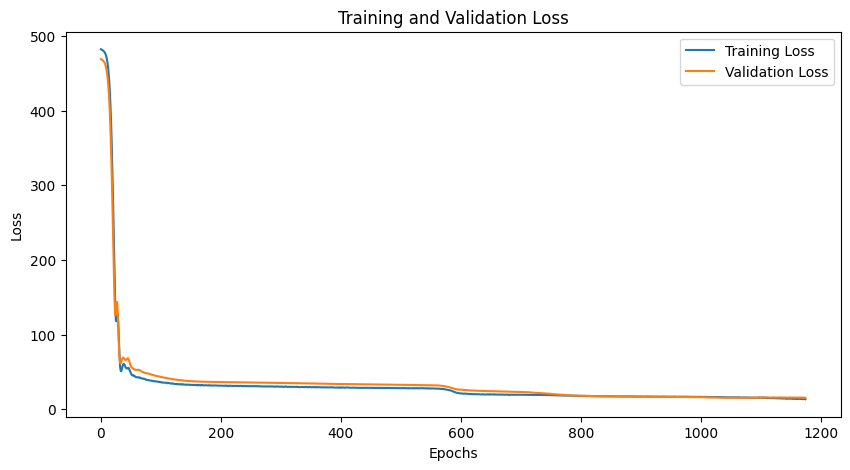

Loss: 17.9579


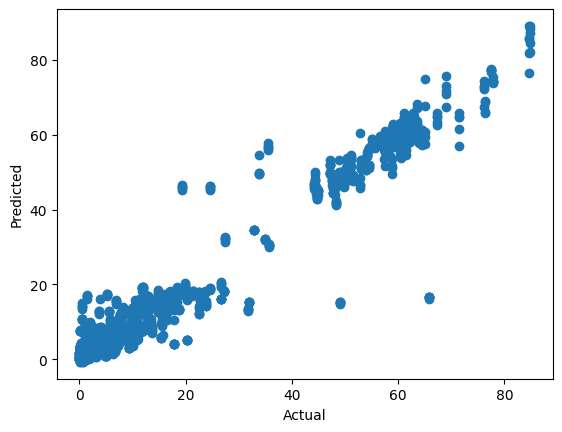

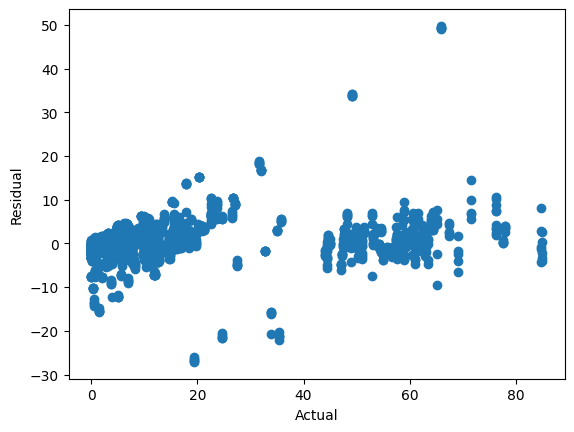

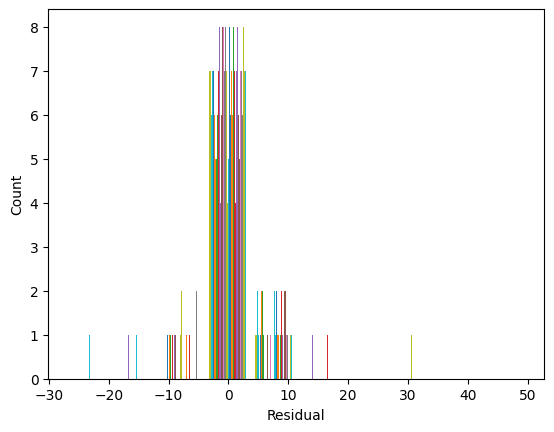

In [18]:
# Plot the loss curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test the model
with torch.no_grad():
    outputs = model(X_test)
    loss = criterion(outputs, y_test)
    print(f'Loss: {loss:.4f}')
    
    # Plot predictions vs actual
    plt.scatter(y_test, outputs)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()
    
    # Plot the residuals
    plt.scatter(y_test, y_test-outputs)
    plt.xlabel('Actual')
    plt.ylabel('Residual')
    plt.show()
    
    # Plot the residuals histogram
    plt.hist(y_test-outputs)
    plt.xlabel('Residual')
    plt.ylabel('Count')
    plt.show()

In [19]:
# calculate RMSEs
rmse = np.sqrt(mean_squared_error(y_test, outputs))
print("RMSE: ", rmse)

RMSE:  4.237676


In [20]:
# rmse for each oxide
rmse_oxides = np.sqrt(mean_squared_error(y_test, outputs, multioutput="raw_values"))
# as dataframe
rmse_oxides = pd.DataFrame(rmse_oxides, index=major_oxides, columns=["RMSE"])

In [21]:
rmse_oxides

,RMSE
SiO2,6.181741
TiO2,0.684651
Al2O3,4.915387
FeOT,7.649093
MgO,3.095083
CaO,2.992828
Na2O,1.561561
K2O,1.155784


In [22]:
paper=5.3+1.03+3.47+2.31+2.21+2.72+0.62+0.82
this=rmse_oxides.sum()

(paper/8), round((sum(this)/8), 2)

(2.31, 3.53)